This script basiclly plot thre already filterd and sorted ( by season ) hourly era5 wind speed data. 
this plots 4 figures ( for different season)
1.  30years average mean hourly  vs each yearly  
2.  Heat map distributon of hourly data fro 30 years
3. Year to year mean hourly differnce
4. box plots showing the average 30 years hourly data 

In [ ]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Setup ===
summary_dir = "/work/bb1198/b383412/Data/hackathon"
output_dir = "/work/bb1198/b383412/Figures/plots/wind_climat_hackaton"
os.makedirs(output_dir, exist_ok=True)

region_name = "west_africa"  # choose: "bodele", "west_africa", or "north_africa"
regions = {
    "bodele": {"lat": (16, 20), "lon": (16, 20)},
    "west_africa": {"lat": (5, 20), "lon": (-18, 5)},
    "north_africa": {"lat": (10, 32), "lon": (-18, 35)}
}
lat_min, lat_max = regions[region_name]["lat"]
lon_min, lon_max = regions[region_name]["lon"]

summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))
seasons = ["DJF", "MAM", "JJA", "SON"]

years = []
season_hourly = {s: [] for s in seasons}

for file in summary_files:
    basename = os.path.basename(file)
    match = re.search(r"summary_(\d{4})_seasonal", basename)
    if not match:
        continue
    year = int(match.group(1))
    try:
        ds = xr.open_dataset(file)
        if "lat" in ds and "lon" in ds:
                mask = ((ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
                (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).compute()
                selected_locs = ds['location'].values[mask]
        for season in seasons:
            if f"{season}_mean" not in ds:
                continue
            arr = ds[f"{season}_mean"].values  # shape: (24, N_locations)
            hourly_mean = np.nanmean(arr, axis=1)  # (24,)
            season_hourly[season].append(hourly_mean)
        years.append(year)
        ds.close()
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

# === Sort years and corresponding data
years, *_ = zip(*sorted(zip(years, *season_hourly.values())))
years = list(years)
for s in seasons:
    season_hourly[s] = [x for _, x in sorted(zip(years, season_hourly[s]))]
    
    

# === Plot 1: Climatology anomaly heatmaps ===
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes1 = axes1.flatten()
for i, season in enumerate(seasons):
    ax = axes1[i]
    data = np.array(season_hourly[season])  # (n_years, 24)
    climatology = np.nanmean(data, axis=0)  # (24,)
    anomaly = data - climatology            # (n_years, 24)
    im = ax.imshow(anomaly, aspect="auto", cmap="RdBu_r", origin="lower",
                   vmin=-1, vmax=1, extent=[0, 23, years[0], years[-1]])
    ax.set_title(f"{season} Wind Speed Anomaly")
    ax.set_xlabel("Hour of Day")
    if i in [0, 2]:
        ax.set_ylabel("Year")
    ax.set_xticks(np.arange(0, 24, 3))
    plt.colorbar(im, ax=ax, label="Δ Wind Speed (m/s)")
region_title = region_name.replace("_", " ").title()
fig1.suptitle(f"{region_title}: Hourly Wind Speed Anomaly vs. Climatology (1994–2023)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig1.savefig(os.path.join(output_dir, f"{region_title}:anomaly_vs_climatology.png"), dpi=300)

# === Plot 2: Absolute values heatmap ===
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes2 = axes2.flatten()
for i, season in enumerate(seasons):
    ax = axes2[i]
    data = np.array(season_hourly[season])
    im = ax.imshow(data, aspect="auto", cmap="viridis", origin="lower",
                   extent=[0, 23, years[0], years[-1]])
    ax.set_title(f"{season} Mean Wind Speed")
    ax.set_xlabel("Hour of Day")
    if i in [0, 2]:
        ax.set_ylabel("Year")
    ax.set_xticks(np.arange(0, 24, 3))
    plt.colorbar(im, ax=ax, label="Wind Speed (m/s)")
fig2.suptitle(f"{region_title}: Hourly Mean Wind Speed by Season (1994–2023)", fontsize=16)
# === Load data ===
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig2.savefig(os.path.join(output_dir,f"{region_title}:absolute_hourly_heatmap.png"), dpi=300)

# === Plot 3: Year-to-year difference ===
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes3 = axes3.flatten()
delta_years = years[1:]
for i, season in enumerate(seasons):
    ax = axes3[i]
    data = np.array(season_hourly[season])  # (n_years, 24)
    delta = np.diff(data, axis=0)           # (n_years - 1, 24)
    im = ax.imshow(delta, aspect="auto", cmap="RdBu_r", origin="lower",
                   vmin=-1.5, vmax=1.5, extent=[0, 23, delta_years[0], delta_years[-1]])
    ax.set_title(f"{season} Year-to-Year Δ Wind Speed")
    ax.set_xlabel("Hour of Day")
    if i in [0, 2]:
        ax.set_ylabel("Year")
    ax.set_xticks(np.arange(0, 24, 3))
    plt.colorbar(im, ax=ax, label="Δ Wind Speed (m/s)")
fig3.suptitle(f"{region_title}: Hourly Year-to-Year Change in Wind Speed (1994–2023)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig3.savefig(os.path.join(output_dir, f"{region_title}:yearly_change_heatmap.png"), dpi=300)

plt.show()





✅ Boxplot saved: /work/bb1198/b383412/Figures/plots/wind_climat_hackaton/west_africa_hourly_boxplot.png


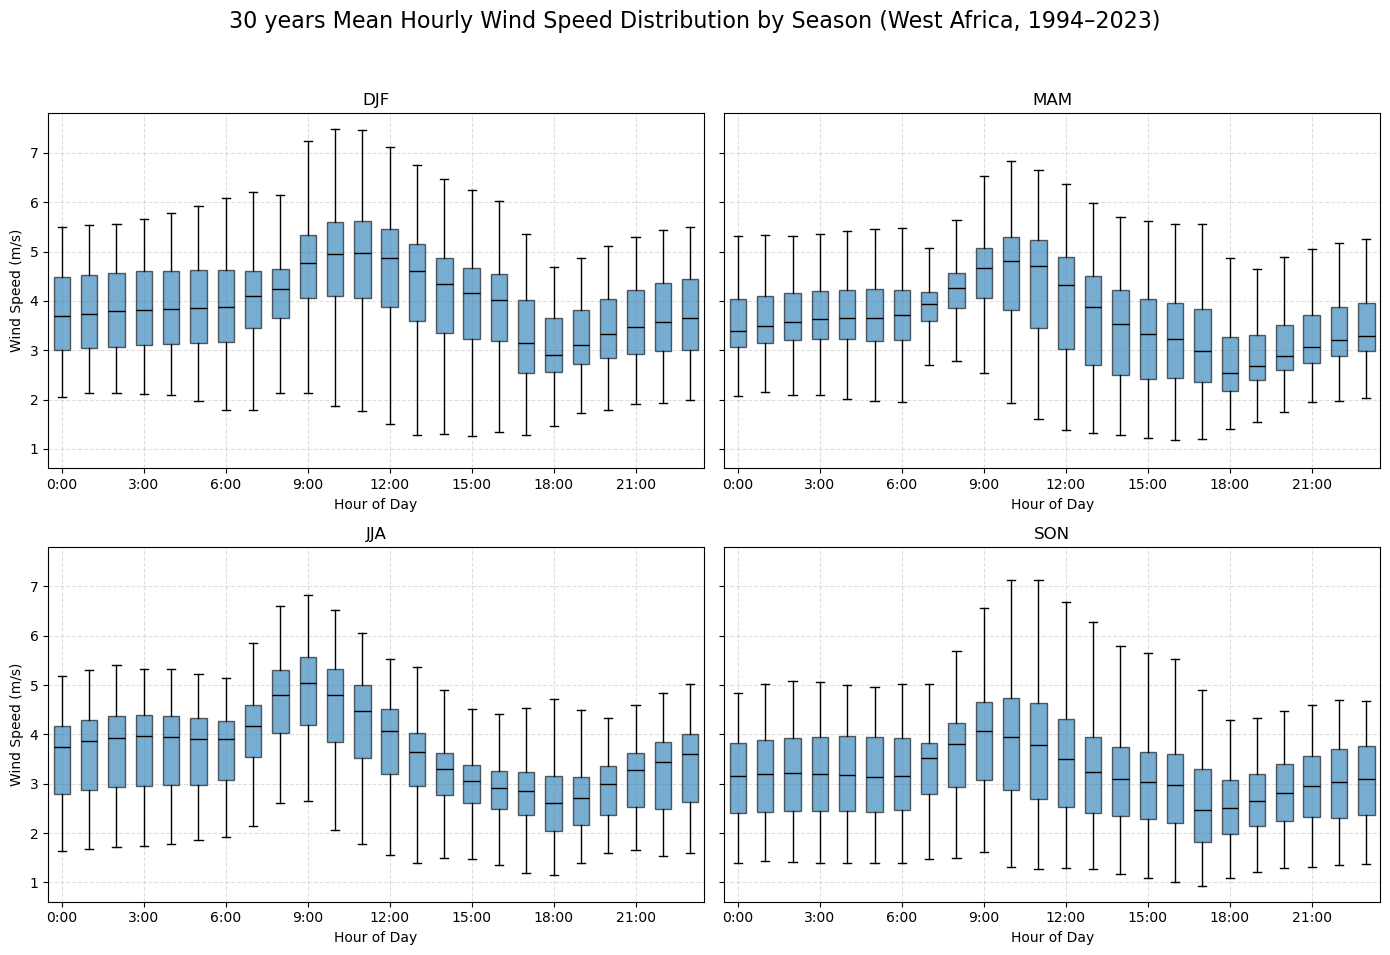

🗺️ Region map saved: /work/bb1198/b383412/Figures/plots/wind_climat_hackaton/west_africa_region_map.png


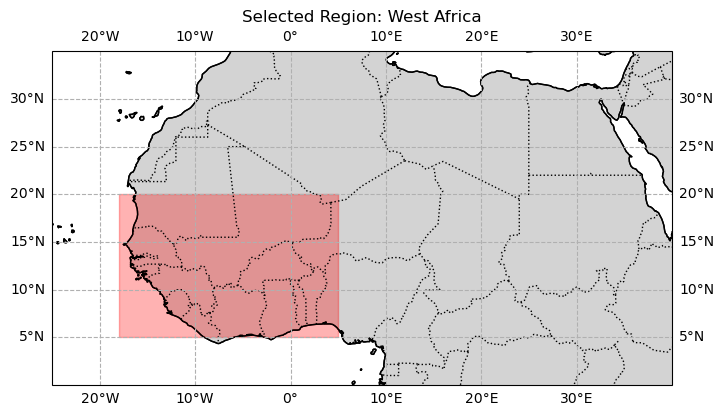

In [11]:
# The next box plot need a separate section and op
# # === Paths ===
# summary_dir = "/work/bb1198/b383412/Data/hackathon"
# output_dir = "/work/bb1198/b383412/Figures/plots"
# os.makedirs(output_dir, exist_ok=True)

# # === Region selector ===
# region_name = "north_africa"  # choose: "bodele", "west_africa", or "north_africa"
# regions = {
#     "bodele": {"lat": (16, 20), "lon": (16, 20)},
#     "west_africa": {"lat": (5, 20), "lon": (-18, 5)},
#     "north_africa": {"lat": (10, 32), "lon": (-18, 35)}
# }
# lat_min, lat_max = regions[region_name]["lat"]
# lon_min, lon_max = regions[region_name]["lon"]

# # === Load data ===
summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))
seasons = ["DJF", "MAM", "JJA", "SON"]
seasonal_data = {s: [] for s in seasons}

for file in summary_files:
    ds = xr.open_dataset(file)
    if "lat" in ds and "lon" in ds:
        mask = ((ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
                (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).compute()
        selected_locs = ds['location'].values[mask]
        for season in seasons:
            if f"{season}_mean" in ds:
                arr = ds[f"{season}_mean"].sel(location=selected_locs).values  # (24, N_locs)
                seasonal_data[season].append(arr)
    ds.close()

# === Plot boxplots ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for i, season in enumerate(seasons):
    data = np.concatenate(seasonal_data[season], axis=1)  # (24, N_total)
    hourly = [data[h, :] for h in range(24)]
    ax = axes[i]

    box = ax.boxplot(hourly, positions=np.arange(24), widths=0.6,
                     showfliers=False, patch_artist=True)

    for patch in box['boxes']:
        patch.set_facecolor("#1f77b4")
        patch.set_alpha(0.6)
        patch.set_edgecolor("black")
    for median in box['medians']:
        median.set_color("black")

    ax.set_title(season)
    ax.set_xticks(np.arange(0, 24, 3))
    ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 3)])
    ax.set_xlabel("Hour of Day")
    if i in [0, 2]:
        ax.set_ylabel("Wind Speed (m/s)")
    ax.grid(True, linestyle="--", alpha=0.4)

fig.suptitle(f"30 years Mean Hourly Wind Speed Distribution by Season ({region_name.replace('_',' ').title()}, 1994–2023)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
boxplot_path = os.path.join(output_dir, f"{region_name}_hourly_boxplot.png")
plt.savefig(boxplot_path, dpi=300)
print(f"✅ Boxplot saved: {boxplot_path}")
plt.show()


# === Plot region map ===
fig_map = plt.figure(figsize=(8, 6))
ax_map = plt.axes(projection=ccrs.PlateCarree())
ax_map.set_extent([-25, 40, 0, 35], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.BORDERS, linestyle=":")
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax_map.gridlines(draw_labels=True, linestyle='--')

# Add shaded region
ax_map.add_patch(plt.Rectangle((lon_min, lat_min),
                                lon_max - lon_min, lat_max - lat_min,
                                fill=True, color='red', alpha=0.3,
                                transform=ccrs.PlateCarree()))
ax_map.set_title(f"Selected Region: {region_name.replace('_', ' ').title()}")
map_path = os.path.join(output_dir, f"{region_name}_region_map.png")
plt.savefig(map_path, dpi=300)
print(f"🗺️ Region map saved: {map_path}")
plt.show()

In [ ]:
print(ds)

In [ ]:
# import xarray as xr
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from glob import glob

# # === Settings ===
# summary_dir = "/work/bb1198/b383412/Data/hackathon"  # Where summary_*.nc files are
# output_plot = "hourly_wind_boxplot.png"

# # === Load all summary files ===
# summary_files = sorted(glob(os.path.join(summary_dir, "summary_*.nc")))

# all_q25 = []
# all_q75 = []
# all_mean = []
# all_q95 = []

# for file in summary_files:
#     ds = xr.open_dataset(file)
#     all_q25.append(ds["q25"].data)   # shape (24, N_locations)
#     all_q75.append(ds["q75"].data)
#     all_mean.append(ds["mean"].data)
#     all_q95.append(ds["q95"].data)
#     ds.close()

# # Stack all years: each becomes a new sample dimension
# q25_all = np.concatenate(all_q25, axis=1)  # shape: (24, N_total_samples)
# q75_all = np.concatenate(all_q75, axis=1)
# mean_all = np.concatenate(all_mean, axis=1)
# q95_all = np.concatenate(all_q95, axis=1)

# # For boxplot, get raw values per hour by merging percentiles
# # We'll use the mean_all as a proxy for center, and min/max percentiles for whiskers
# hourly_data = [mean_all[hour, :] for hour in range(24)]  # list of arrays, one per hour

# # === Plotting ===
# plt.figure(figsize=(12, 6))
# plt.boxplot(hourly_data, positions=np.arange(24), widths=0.6, showfliers=False)

# plt.xticks(np.arange(24), labels=[f"{h}:00" for h in range(24)])
# plt.xlabel("Hour of Day")
# plt.ylabel("Wind Speed (m/s)")
# plt.title("Hourly Wind Speed Distribution (North Africa, 1994–1995)")
# plt.grid(True, linestyle="--", alpha=0.4)
# plt.tight_layout()
# plt.savefig(output_plot, dpi=300)
# plt.show()


In [ ]:
# # over all box plot


# import xarray as xr
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from glob import glob

# # === Paths ===
# summary_dir = "/work/bb1198/b383412/Data/hackathon"  # directory with summary_*_seasonal.nc files
# output_plot = "/work/bb1198/b383412/Figures/plots/seasonal_hourly_wind_boxplots_1994.png"

# # === Seasons
# seasons = ["DJF", "MAM", "JJA", "SON"]
# summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))

# # === Initialize containers
# seasonal_data = {s: [] for s in seasons}

# # === Load and stack all data
# for file in summary_files:
#     ds = xr.open_dataset(file)
#     for season in seasons:
#         # Use 'mean' as central value proxy
#         mean = ds[f"{season}_mean"].data  # shape (24, N_locations)
#         seasonal_data[season].append(mean)
#     ds.close()

# # === Prepare plot layouta
# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
# axes = axes.flatten()

# for i, season in enumerate(seasons):
#     # Stack all years' data: (n_years * n_locs) samples per hour
#     data = np.concatenate(seasonal_data[season], axis=1)  # (24, N_total)
#     hourly = [data[h, :] for h in range(24)]  # list of 1D arrays
#     ax = axes[i]

#     # --- ADD patch_artist=True ---
#     box = ax.boxplot(hourly, positions=np.arange(24), widths=0.6,
#                      showfliers=False, patch_artist=True)

#     # --- FILL with blue ---
#     for patch in box['boxes']:
#         patch.set_facecolor("#1f77b4")  # Blue
#         patch.set_alpha(0.6)            # Optional transparency
#         patch.set_edgecolor("black")

#     for median in box['medians']:
#         median.set_color("black")

#     ax.set_title(season)
#     ax.set_xticks(np.arange(0, 24, 3))
#     ax.set_xticklabels([f"{h}:00" for h in range(0, 24, 3)])
#     ax.set_xlabel("Hour of Day")
#     if i in [0, 2]:
#         ax.set_ylabel("Wind Speed (m/s)")
#     ax.grid(True, linestyle="--", alpha=0.4)

# fig.suptitle("Hourly Wind Speed Distribution by Season (North Africa, 1994–2023)", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(output_plot, dpi=300)
# plt.show()


In [ ]:

# #all mean data
# import xarray as xr
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from glob import glob
# import re

# summary_dir = "/work/bb1198/b383412/Data/hackathon"
# plot_file = "/work/bb1198/b383412/Figures/plots/hourly_yearly_wind_heatmap.png"
# summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))

# seasons = ["DJF", "MAM", "JJA", "SON"]
# years = []
# season_hourly = {s: [] for s in seasons}

# # === Load data
# for file in summary_files:
#     match = re.search(r"summary_(\d{4})_seasonal", os.path.basename(file))
    
#     if not match:
#         continue
#     year = int(match.group(1))
#     ds = xr.open_dataset(file)

#     for season in seasons:
#         if f"{season}_mean" not in ds:
#             continue
#         arr = ds[f"{season}_mean"].sel(location=selected_locs).values  # shape: (24, n_bodele_locs)
#         hourly_mean = np.nanmean(arr, axis=1)
#         season_hourly[season].append(hourly_mean)
#     for season in seasons:
#         arr = ds[f"{season}_mean"].values  # shape (24, N_locations)
#         hourly_mean = np.nanmean(arr, axis=1)  # shape (24,)
#         season_hourly[season].append(hourly_mean)
#     years.append(year)
#     ds.close()

# # === Plot heatmaps
# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, season in enumerate(seasons):
#     ax = axes[i]
#     data = np.array(season_hourly[season])  # shape (years, hours)
#     im = ax.imshow(data, aspect="auto", cmap="viridis", origin="lower",
#                    extent=[0, 23, years[0], years[-1]])

#     ax.set_title(season)
#     ax.set_xlabel("Hour of Day")
#     if i in [0, 2]:
#         ax.set_ylabel("Year")
#     ax.set_xticks(np.arange(0, 24, 3))
#     fig.colorbar(im, ax=ax, label="Wind Speed (m/s)")

# plt.suptitle("Hourly Mean Wind Speed by Year and Season (North Africa 1994–2023)", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(plot_file, dpi=300)
# plt.show()


In [ ]:
# year to year difference

# import xarray as xr
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from glob import glob
# import re

# summary_dir = "/work/bb1198/b383412/Data/hackathon"
# plot_file = "/work/bb1198/b383412/Figures/plots/hourly_wind_change_heatmap.png"
# summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))

# seasons = ["DJF", "MAM", "JJA", "SON"]
# years = []
# season_hourly = {s: [] for s in seasons}

# # === Load data
# for file in summary_files:
#     basename = os.path.basename(file)
#     match = re.search(r"summary_(\d{4})_seasonal", basename)
#     if not match:
#         continue
#     year = int(match.group(1))
#     try:
#         ds = xr.open_dataset(file)
#         for season in seasons:
#             if f"{season}_mean" not in ds:
#                 continue
#             arr = ds[f"{season}_mean"].values  # (24, N_locations)
#             hourly_mean = np.nanmean(arr, axis=1)  # (24,)
#             season_hourly[season].append(hourly_mean)
#         years.append(year)
#         ds.close()
#     except Exception as e:
#         print(f"❌ Error reading {file}: {e}")

# # Sort by year
# years, *_ = zip(*sorted(zip(years, *season_hourly.values())))
# for s in seasons:
#     season_hourly[s] = [x for _, x in sorted(zip(years, season_hourly[s]))]
# years = list(years)

# # === Compute differences
# season_deltas = {}
# for s in seasons:
#     data = np.array(season_hourly[s])  # shape: (years, 24)
#     delta = np.diff(data, axis=0)      # shape: (years-1, 24)
#     season_deltas[s] = delta

# # === Plot
# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# axes = axes.flatten()
# delta_years = years[1:]

# for i, season in enumerate(seasons):
#     ax = axes[i]
#     delta = season_deltas[season]
#     im = ax.imshow(delta, aspect="auto", cmap="RdBu_r", origin="lower",
#                    vmin=-1.5, vmax=1.5,
#                    extent=[0, 23, delta_years[0], delta_years[-1]])

#     ax.set_title(f"{season} Year-to-Year Δ Wind Speed")
#     ax.set_xlabel("Hour of Day")
#     if i in [0, 2]:
#         ax.set_ylabel("Year")
#     ax.set_xticks(np.arange(0, 24, 3))
#     fig.colorbar(im, ax=ax, label="Δ Wind Speed (m/s)")

# plt.suptitle("Hourly Year-to-Year Change in Mean Wind Speed (North Africa 1994-2023)", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(plot_file, dpi=300)
# plt.show()


In [ ]:
# # climatology vs each year

# import xarray as xr
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from glob import glob
# import re

# summary_dir = "/work/bb1198/b383412/Data/hackathon"
# plot_file = "/work/bb1198/b383412/Figures/plots/hourly_wind_anomalies_climatology_heatmap.png"
# summary_files = sorted(glob(os.path.join(summary_dir, "summary_*_seasonal.nc")))

# seasons = ["DJF", "MAM", "JJA", "SON"]
# years = []
# season_hourly = {s: [] for s in seasons}

# # === Load data
# for file in summary_files:
#     basename = os.path.basename(file)
#     match = re.search(r"summary_(\d{4})_seasonal", basename)
#     if not match:
#         continue
#     year = int(match.group(1))
#     try:
#         ds = xr.open_dataset(file)
#         for season in seasons:
#             if f"{season}_mean" not in ds:
#                 continue
#             arr = ds[f"{season}_mean"].values  # shape: (24, N_locations)
#             hourly_mean = np.nanmean(arr, axis=1)  # shape: (24,)
#             season_hourly[season].append(hourly_mean)
#         years.append(year)
#         ds.close()
#     except Exception as e:
#         print(f"❌ Error reading {file}: {e}")

# # Sort years and corresponding data
# years, *_ = zip(*sorted(zip(years, *season_hourly.values())))
# for s in seasons:
#     season_hourly[s] = [x for _, x in sorted(zip(years, season_hourly[s]))]
# years = list(years)

# # === Compute anomaly from long-term mean
# season_anomalies = {}
# for s in seasons:
#     data = np.array(season_hourly[s])  # shape: (n_years, 24)
#     climatology = np.nanmean(data, axis=0)  # shape: (24,)
#     anomaly = data - climatology  # broadcast subtraction
#     season_anomalies[s] = anomaly

# # === Plot
# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, season in enumerate(seasons):
#     ax = axes[i]
#     anomaly = season_anomalies[season]  # shape (years, hours)
#     im = ax.imshow(anomaly, aspect="auto", cmap="RdBu_r", origin="lower",  #"RdBu_r"
#                    vmin=-1, vmax=1,
#                    extent=[0, 23, years[0], years[-1]])

#     ax.set_title(f"{season} Wind Speed Anomaly (vs. Climatology)")
#     ax.set_xlabel("Hour of Day")
#     if i in [0, 2]:
#         ax.set_ylabel("Year")
#         ax.set_xticks(np.arange(0, 24, 3))
        

#     fig.colorbar(im, ax=ax, label="Δ Wind Speed (m/s)")

# plt.suptitle("Hourly Mean Wind Speed vs. 30-Year Average (North Africa 1994–2023)", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig(plot_file, dpi=300)
# plt.show()
